In [1]:
from collections import defaultdict
from fastai.vision.all import *

In [2]:
torch.cuda.set_device(0)

## Get Points project

In [4]:
out_path = Path('/data2/ashaw/WAMRI/DCNet/data/cytospin')
out_path.mkdir(parents=True, exist_ok=True)

## Process Labels to Centroids

In [5]:
def points2centroid(label_data):
    "Converts segmentation `label: String!` into polygons"
    centroids = []
    for xy_list in label_data:
        if 'geometry' in xy_list:  # V3
            p = xy_list['geometry']
            
            x,y = p['x'], p['y']
            centroids.append((x,y))
    return centroids

def newapi_points2centroid(label):
    results = defaultdict(list)
    for obj in label['objects']:
        title, pt = obj['title'], obj['point']
        x, y = pt['x'], pt['y']
        results[title].append((x,y))
    return results

def json2centroid(label):
    if 'objects' in label: return newapi_points2centroid(label)
    return {k:points2centroid(v) for k,v in label.items()}

## Mask

In [6]:
Eosinophil      = (1, 0.6,   0)  # orange
Lymphocyte      = (0,   1,   0)  # green
MacroMono       = (1,   0,   0)  # red 
Neutrophil      = (0,   1,   1)  # cyan

TILE_SZ = 1024

class_map = {
    # LBName: (idx, display, color, radius)
    'Eosinophil': (0, 'Eosinophil', Eosinophil, 50/TILE_SZ),
    'Lymphocyte': (1, 'Lymphocyte', Lymphocyte, 30/TILE_SZ),
    'Macrophage': (2, 'Macro+Mono', MacroMono,  100/TILE_SZ),
    'Monocyte':   (2, 'Macro+Mono', MacroMono,  100/TILE_SZ),
    'Neutrophil': (3, 'Neutrophil', Neutrophil, 50/TILE_SZ)
}

classes = sorted(set(class_map.values()))
classes

[(0, 'Eosinophil', (1, 0.6, 0), 0.048828125),
 (1, 'Lymphocyte', (0, 1, 0), 0.029296875),
 (2, 'Macro+Mono', (1, 0, 0), 0.09765625),
 (3, 'Neutrophil', (0, 1, 1), 0.048828125)]

In [7]:
# taken from https://github.com/xingyizhou/CenterNet/blob/819e0d0dde02f7b8cb0644987a8d3a370aa8206a/src/lib/utils/image.py

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

In [8]:
import numpy
from PIL import Image, ImageDraw

def centroid2mask(img, point2lbl, c=len(classes)):
    w,h = img.shape
    img_msk = np.zeros((c,w,h))
    
    for k,v in point2lbl.items():
        if k not in class_map: continue
        idx,label,color,radius = class_map[k]
        for pt in v:
            x,y = [p*w/TILE_SZ for p in pt]
            draw_umich_gaussian(img_msk[idx], (x,y), radius=int(radius*w))
    return img_msk

In [9]:
# Cell
class TensorHeatMap(TensorMask):
    _show_args = {'interpolation': 'nearest'}

    def show(self, ctx=None, alpha=1.0, mask_alpha=1.0, **kwargs):
        for m, (_,_,c,_) in zip(self,classes):
            nodes = [0.0, 1.0]
            cs = [[0,0,0,0],c]
            cmap = LinearSegmentedColormap.from_list("cmap", list(zip(nodes, cs)))
            show_image(m, ctx=ctx, cmap=cmap, alpha=mask_alpha, **{**self._show_args, **kwargs})

In [10]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

patches = [mpatches.Patch(color=color, label=label) for idx,label,color,radius in classes]
def show_legend(): plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper left')

## Generate Masks for all rows

In [15]:
with open(out_path/'labels.json', 'r') as f:
    img2lbl = json.load(f)

In [31]:
def parse_pairs(row_data, sz=256, img_dir=out_path):
    label = row_data['label']
    img_path = out_path/row_data['image']
    if img_path.exists():
        img = PILImage.create(img_path)
    else:
        print('Could not locate image:', img_path)
    img = img.resize((sz,sz))
    mask = centroid2mask(img, label)
    return img, mask

In [32]:
img2msk = []
from fastprogress.fastprogress import progress_bar

for row in progress_bar(img2lbl):  # generate masks for train/valid datasets
    img, mask = parse_pairs(row)
    img2msk.append((img, mask))
    
len(img2msk)

760

In [33]:
@patch
def affine_coord(x: TensorHeatMap, mat=None, coord_tfm=None, sz=None, mode='nearest',
                 pad_mode=PadMode.Reflection, align_corners=True):
    add_dim = (x.ndim==3)
    if add_dim: x = x[:,None]
    res = TensorImage.affine_coord(x.float(), mat, coord_tfm, sz, mode, pad_mode, align_corners)#.long() - We use gaussian kernels. Mask must be float
    if add_dim: res = res[:,0]
    return TensorHeatMap(res)


In [34]:
def get_x(idx): return PILImage(img2msk[idx][0])
def get_y(idx): return TensorHeatMap(img2msk[idx][1])

In [35]:
idxs = range(len(img2msk))   
splits = RandomSplitter(seed=42)(idxs)
dsets = Datasets(items=idxs, tfms=[[get_x, ToTensor, IntToFloatTensor], [get_y]], splits=splits)

### TODO add new evaluation session for holdout dataset at the bottom of this notebook


In [36]:
bs = 24  # for Andrew

In [37]:
batch_tfms = [*aug_transforms(max_zoom=1.0, max_warp=0, max_rotate=45, flip_vert=True), Normalize.from_stats(*imagenet_stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)#, shuffle_train=False)

xb,yb = dls.one_batch()
xb.shape, yb.shape

(yb >= 1.0).sum()

TensorHeatMap(339, device='cuda:2')

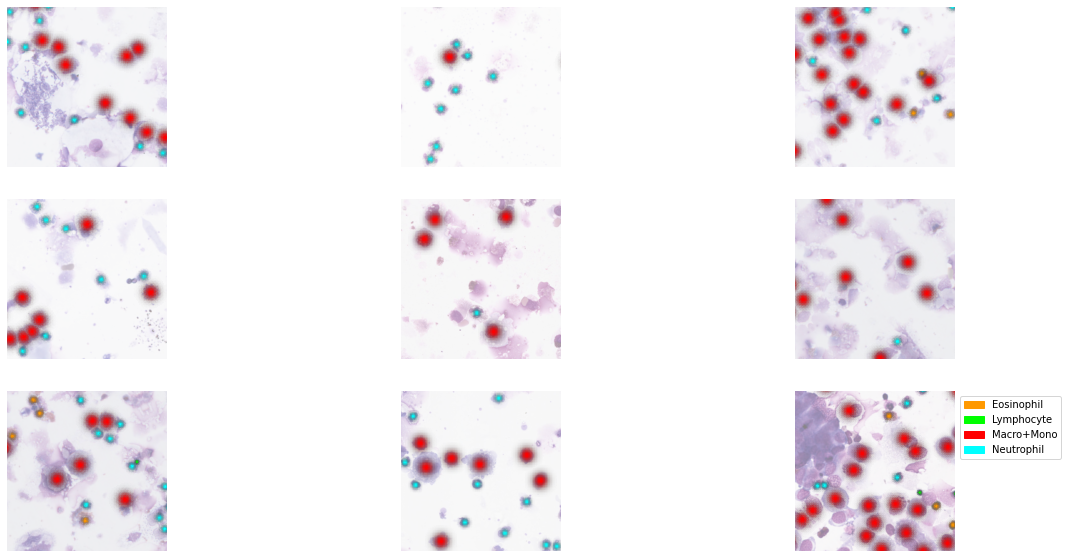

In [38]:
dls.show_batch(figsize=(20,10), alpha=0.5)
show_legend()

## Train Model

In [39]:
def acc_nuclei(input, target):
    mask = target > 0.1
    acc = (input[mask] > 0.1) == (target[mask] > 0.1)
    return acc.float().mean()

In [40]:

def _neg_loss(pred, gt, eps=1e-12):
    ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
    '''
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, 4)

    loss = 0

    pos_loss = torch.log(pred + eps) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred + eps) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0: 
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

class FocalLoss(nn.Module):
    '''nn.Module warpper for focal loss'''
    def __init__(self, loss=_neg_loss):
        super().__init__()
        self.neg_loss = loss

    def forward(self, out, target):
        
        bs,ch = target.shape[:2]
        sout = torch.sigmoid(out)
        loss1 = self.neg_loss(sout, target.data)
        loss1 = loss1.sum() / bs
        return loss1
    
    def activation(self, x): return torch.sigmoid(x)

In [41]:
dls.c = len(classes)
loss_func = FocalLoss()
learn = unet_learner(dls, resnet34, metrics=acc_nuclei, loss_func=loss_func, pretrained=True)
learn.path = out_path

In [46]:
learn.freeze()
learn.loss_func = FocalLoss(F.mse_loss)
learn.fit(1, 1e-4, wd=1e-5)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.002777,0.000401,0.000035,00:09


In [47]:
learn.loss_func = FocalLoss()
learn.fit(4, 2e-4, wd=1e-5)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.342807,0.137281,0.000000,00:06
1,0.225668,0.131376,0.000000,00:06
2,0.177659,0.098845,0.000000,00:06
3,0.149289,0.086088,0.000000,00:06


In [48]:
learn.unfreeze()
learn.fit_one_cycle(60, 5e-4, wd=1e-5)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.087175,0.081803,0.000002,00:07
1,0.085668,0.079289,0.000016,00:07
2,0.083270,0.072994,0.000563,00:07
3,0.080231,0.068554,0.001490,00:07
4,0.077911,0.065170,0.002483,00:07
5,0.074247,0.060589,0.004207,00:07
6,0.071775,0.060980,0.001109,00:07
7,0.069697,0.096590,0.000481,00:07
8,0.074355,0.068322,0.000131,00:07
9,0.072215,0.054571,0.001149,00:07


In [49]:
learn.save('centernet-adaptive-radius')

Path('models/3g_latest.pth')

## Load

In [44]:
import cv2
from functools import partial
from scipy import stats

In [46]:
learn.load('centernet-adaptive-radius')

## Metrics

In [47]:
preds, lbls = learn.get_preds()
preds = preds.detach().cpu().numpy()
lbls = lbls.detach().cpu().numpy()

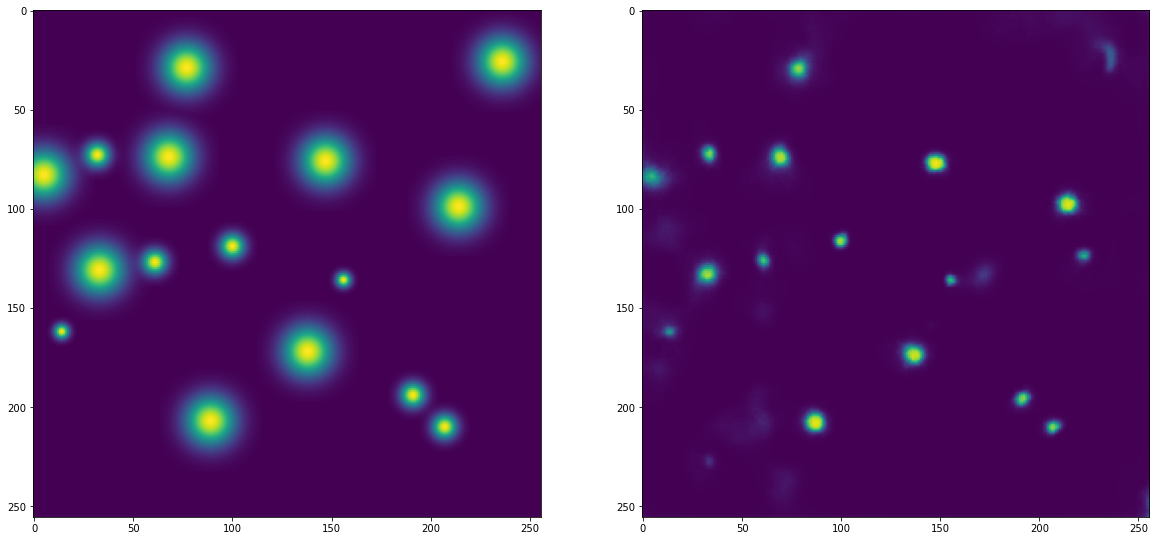

In [48]:
fix, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,20))
ax[0].imshow(lbls[0].sum(0))
ax[1].imshow(preds[0].sum(0), vmin=0, vmax=1)

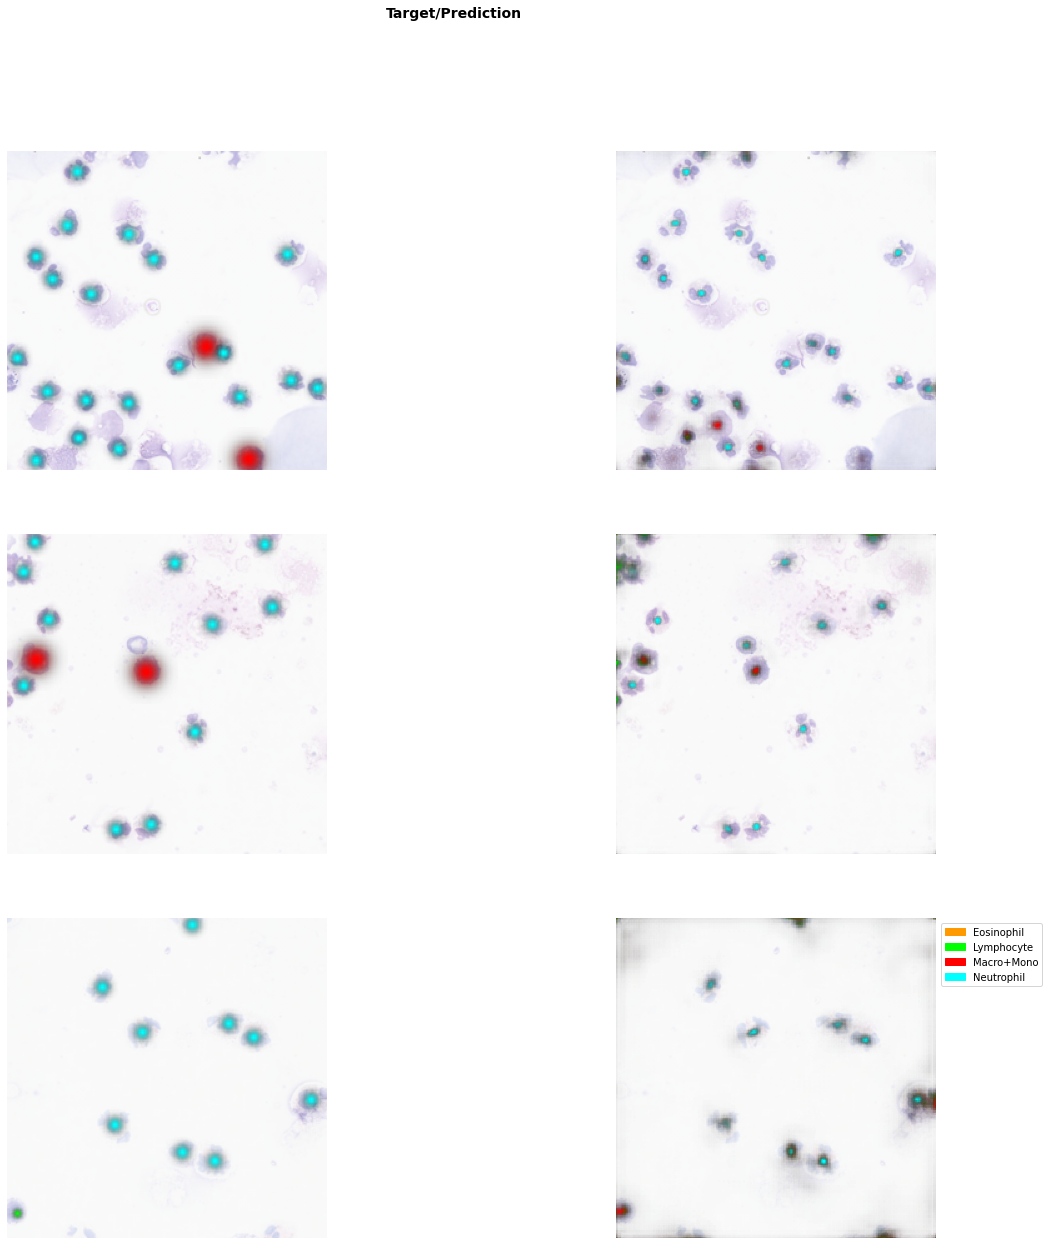

In [49]:
learn.show_results(alpha=0.5, figsize=(20,20))
show_legend()

# visualize to points

In [38]:
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

def max_px(box, targ):
    m = np.zeros_like(targ)
    y,x,h,w = box
    m[:, x:x+w,y:y+h] = 1
    ind = np.unravel_index(np.argmax(targ*m, axis=None), targ.shape)
    return ind

def euclidean_dist(pt1, pt2):
    (xA,yA), (xB,yB) = pt1, pt2
    return ((xB-xA)**2 + (yB-yA)**2)**0.5

In [ ]:
def extract_predictions(lbl, pred, score_thresh=0.1):
    pscore = (pred > score_thresh).astype(np.uint8)
    contours,hierarchy = cv2.findContours(pscore.max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    pboxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) >= min_area]
    pred_points = [max_px(pbox, pred) for pbox in pboxes]
    
    lbl_points = list(zip(*(lbl==1.0).nonzero()))
    
    return pred_points, lbl_points

In [40]:
def calc_class_ap(lbls, preds, min_area=4, iou_thresh=0.1, score_thresh=0.3):
    metrics = {}
    for idx,lbl,color,radius in classes:
        metrics[lbl] = [],[],[],[]
        
    for lbl,pred in zip(lbls,preds): # iterate through labels and predictions
        pred_points, lbl_points = extract_predictions(lbl, pred, score_thresh)
        
        for idx,cls,color,radius in classes: # calculate ap per class
            tps, fps, scores, n_gts = metrics[cls]
            
            ppoints = [pp for pp in pred_points if pp[0] == idx]
            ppoints = list(sorted(ppoints, key=lambda x: pred[x], reverse=True)) # sort by scores
            lpoints = [lb for lb in lbl_points if lb[0] == idx]

            pdists = []
            pscores = []
            matched = set()
            for ppoint in ppoints:
                all_dists = [(euclidean_dist(lpoint[1:], ppoint[1:]), lpoint) for lpoint in lpoints if lpoint not in matched]
                if len(all_dists) == 0:
                    pdists.append(1e10)
                else:
                    pdist, lpoint = min(all_dists)
                    matched.add(lpoint) # Found match. Remove label so it can't be matched again
                    pdists.append(pdist)
                pscores.append(pred[ppoint])
                
            w,h = lbl.shape[-2:]
            max_dist = radius * w * iou_thresh
            
            tp = (np.array(pdists) < max_dist)
            fp = ~tp

            n_gts.append(len(lpoints))
            tps.extend(tp.astype(np.uint8).tolist())
            fps.extend(fp.astype(np.uint8).tolist())
            scores.extend(pscores)
        
    aps = []
    for idx,cls,color,radius in classes:
        tps, fps, scores, n_gts = metrics[cls]
        res = sorted(zip(scores, tps, fps), key=lambda x: x[0], reverse=True)
        res = np.array(res)
        if len(res) == 0: res = np.zeros((1, 3))
        tp = res[:,1].cumsum(0)
        fp = res[:,2].cumsum(0)
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (sum(n_gts) + 1e-8)
        
        aps.append({ 
            'class': cls, 
            'ap': round(compute_ap(precision, recall), 4), 
            'tp': int(tp[-1]), 
            'fp': int(fp[-1]), 
            'gt': sum(n_gts)
        })
        
    aps.append({
        'class': 'all',
        'ap': np.mean([x['ap'] for x in aps]),
        'tp': sum([x['tp'] for x in aps]),
        'fp': sum([x['fp'] for x in aps]),
        'gt': sum([x['gt'] for x in aps]),
    })
    return aps

## Used to calculate Table 4 - Average Precision

In [42]:
thresh = []
for iou_thresh in [0.1, 0.25, 0.5]:
    aps = []
    for score_thresh in [0.05, 0.1, 0.2, 0.4]:
        for min_area in [2,3,4]:
            ccap = calc_class_ap(lbls,preds, score_thresh=score_thresh, min_area=min_area, iou_thresh=iou_thresh)
            aps.append((ccap[-1]['ap'], score_thresh, min_area))
    print(iou_thresh, max(aps))
    thresh.append((iou_thresh,) + max(aps)[1:])

0.1 (0.13895, 0.1, 4)
0.25 (0.658125, 0.1, 3)
0.5 (0.780025, 0.1, 3)


In [43]:
for iou_thresh, score_thresh, min_area in thresh:
    df = pd.DataFrame(calc_class_ap(lbls,preds, score_thresh=score_thresh, min_area=min_area, iou_thresh=iou_thresh))
    print(f'iou_thresh', iou_thresh, f'score_thresh', score_thresh, f'min_area', min_area, 'all', df.iloc[-1]['ap'])
    print(df)
    print("")

iou_thresh 0.1 score_thresh 0.1 min_area 4 all 0.13895
        class       ap   tp    fp    gt
0  Eosinophil  0.11760   26    66    86
1  Lymphocyte  0.04880   19   124   107
2  Macro+Mono  0.27760  285   529   637
3  Neutrophil  0.11180  108   376   399
4         all  0.13895  438  1095  1229

iou_thresh 0.25 score_thresh 0.1 min_area 3 all 0.658125
        class        ap   tp   fp    gt
0  Eosinophil  0.756700   69   23    86
1  Lymphocyte  0.550100   75   72   107
2  Macro+Mono  0.699000  469  351   637
3  Neutrophil  0.626700  283  207   399
4         all  0.658125  896  653  1229

iou_thresh 0.5 score_thresh 0.1 min_area 3 all 0.780025
        class        ap   tp   fp    gt
0  Eosinophil  0.828300   73   19    86
1  Lymphocyte  0.723200   86   61   107
2  Macro+Mono  0.759000  501  319   637
3  Neutrophil  0.809600  335  155   399
4         all  0.780025  995  554  1229



## Visualize Results

In [150]:
# Cell
class TensorMultiPoint(TensorBase):
    _show_args = dict(s=100, marker='.')

    @classmethod
    def create(cls, t, img_size=None)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).float(), img_size=img_size)

    def show(self, ctx=None, cmap=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        for (cls_idx,_,color,_) in classes:
            pts = np.array([(y,x) for idx,x,y in self if idx==cls_idx])
            if len(pts) == 0: continue
            ctx.scatter(pts[:, 0], pts[:, 1], color=color, **{**self._show_args, **kwargs})
        return ctx
    

In [162]:
inps,preds,lbls = learn.get_preds(with_input=True)
preds = preds.detach().cpu().numpy()
lbls = lbls.detach().cpu().numpy()
out = dls.decode_batch((inps, lbls))

In [163]:
idx = 0
inp, _ = out[idx]
pred, lbl = preds[idx], lbls[idx]
pred_points, lbl_points = extract_predictions(lbl, pred, score_thresh=0.1)

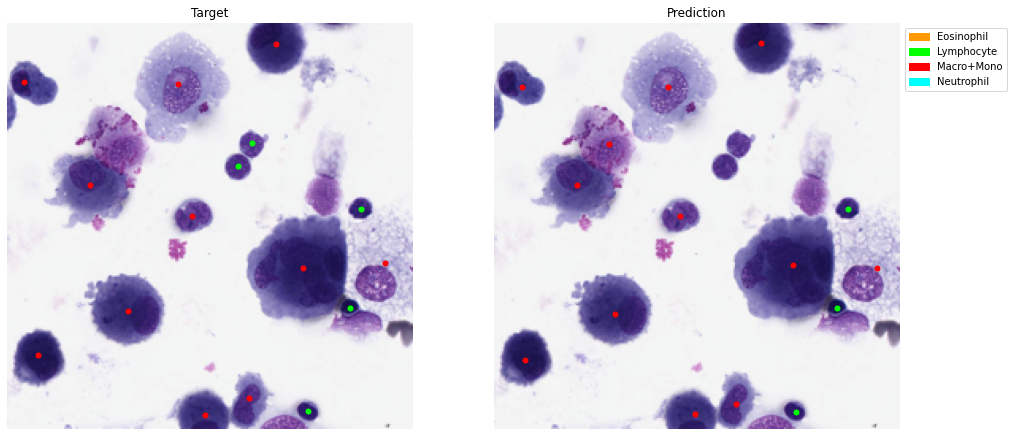

In [164]:
fig, ax = plt.subplots(ncols=2, figsize=(16,16))

ax[0].set_title('Target')
ctx = inp.show(ax[0])
TensorMultiPoint(pred_points).show(ctx=ctx)

ax[1].set_title('Prediction')
ctx = inp.show(ax[1])
TensorMultiPoint(lbl_points).show(ctx=ctx)

show_legend()